# Mapping Myocardial Surface into Bull's eye plot

 - Extract centerline from base to apex
 - Extract cross-sections along the centerline
 - Rotate the coordinate system so that z-axis would be the centerline of the myocardium:
    - phi = np.arccos(np.clip(np.dot(dir_centerline, [0, 0, 1]), -1, 1))
    - rotation matrix = [

        cos(phi)  sin(phi)    0

        -sin(phi) cos(phi)    0

            0       0         1
    
    ]
 - on each cross section calculate and return:
    - r = sqrt(x^2, y^2)
    - theta = arctan2(y, x)
 - Reconstrcut final plot using r and theta, and return Ischemic and territory profile at each point.

In [27]:
import os

InputFolder = "/Users/ana/Documents/AnahitaSeresti/04_Tesselation/BullsEye/SU04A"
slice_base = os.path.join(InputFolder, "SliceBase.vtp")
slice_apex = os.path.join(InputFolder, "SliceApex.vtp")
myocardium = os.path.join(InputFolder, "MyocardiumSurface.vtp")
ischemic = os.path.join(InputFolder, "Projected_Territories_L_LCx_0+L_LCx_1+L_LCx_2.vtp")


In [28]:
import vtk
import numpy as np
from utilities import ReadVTPFile, GetCentroid, WriteVTPFile

centeroid_base = GetCentroid(ReadVTPFile(slice_base))
centeroid_apex = GetCentroid(ReadVTPFile(slice_apex))
Myocardium = ReadVTPFile(myocardium)
Ischemic = ReadVTPFile(ischemic)

In [29]:
def Line(point1, point2, res):
    line = vtk.vtkLineSource()
    line.SetPoint1(point1)
    line.SetPoint2(point2)
    line.SetResolution(res)
    line.Update()
    
    return line.GetOutput()

def BoldLine(centerline):
    tube_filter = vtk.vtkTubeFilter()
    tube_filter.SetInputData(centerline)
    tube_filter.SetRadius(0.02)  # Adjust this value to change thickness
    tube_filter.SetNumberOfSides(50)  # Higher = smoother tube
    tube_filter.CappingOn()  # Close tube ends
    tube_filter.Update()
    
    return tube_filter.GetOutput()

def ThresholdInBetweenPoints(Surface, arrayname, value1, value2):
    Threshold=vtk.vtkThresholdPoints()
    Threshold.SetInputData(Surface)
    Threshold.SetLowerThreshold(value1)
    Threshold.SetUpperThreshold(value2)
    #Threshold.ThresholdBetween(value1,value2)
    Threshold.SetInputArrayToProcess(0,0,0,vtk.vtkDataObject.FIELD_ASSOCIATION_POINTS,arrayname)
    Threshold.Update()
    return Threshold.GetOutput()

In [30]:
CL_dir = np.array([
    centeroid_base[0] - centeroid_apex[0],
    centeroid_base[1] - centeroid_apex[1],
    centeroid_base[2] - centeroid_apex[2],
])
CL_direction = CL_dir/np.linalg.norm(CL_dir)

point0 = np.array([
    centeroid_base[0] + CL_direction[0]*2,
    centeroid_base[1] + CL_direction[1]*2,
    centeroid_base[2] + CL_direction[2]*2
])

point1 = np.array([
    centeroid_apex[0] - CL_direction[0]*1.5,
    centeroid_apex[1] - CL_direction[1]*1.5,
    centeroid_apex[2] - CL_direction[2]*1.5
])

centerline = Line(point0,point1,1000)
WriteVTPFile(os.path.join(InputFolder, "centerline.vtp"), BoldLine(centerline))

In [5]:
def SliceWPlane(Volume,Origin,Norm):
    plane=vtk.vtkPlane()
    plane.SetOrigin(Origin)
    plane.SetNormal(Norm)
    Slice=vtk.vtkCutter()
    Slice.GenerateTrianglesOff()
    Slice.SetCutFunction(plane)
    Slice.SetInputData(Volume)
    Slice.Update()
    
    return Slice.GetOutput()

from scipy.spatial.transform import Rotation as R
from vtk.util.numpy_support import vtk_to_numpy, numpy_to_vtk

append_filter = vtk. vtkAppendPolyData()
for i in range(centerline.GetNumberOfPoints()):
    point = centerline.GetPoint(i)
    slice_ = SliceWPlane(Myocardium, point, CL_direction)
    
    append_filter.AddInputData(slice_)

append_filter.Update()
WriteVTPFile(os.path.join(InputFolder, "slices.vtp"), append_filter.GetOutput())


In [ ]:
#from vtk.util.numpy_support import vtk_to_numpy, numpy_to_vtk
from scipy.spatial.transform import Rotation as R
i = 20
point = centerline.GetPoint(i)
slice_ = SliceWPlane(Myocardium, point, CL_direction)
IschemicProfile = slice_.GetPointData().GetArray("IschemicProfile")
coords = []
rotation, _ = R.align_vectors([[0, 0, 1]], [CL_direction])
r_ = 0
theta_ = []
for i in range(slice_.GetNumberOfPoints()):
    coord_ = slice_.GetPoint(i)
    aligned_coord_ = rotation.apply(coord_)
    theta_.append(np.arctan2(aligned_coord_[1], aligned_coord_[0]))
    r_ += np.sqrt(aligned_coord_[0]**2 + aligned_coord_[1]**2)
    coords.append(coord_)

r_ /= slice_.GetNumberOfPoints()
new_coords = []
for angle in theta_:
    new_coords.append([r_*np.cos(angle), r_*np.sin(angle), 0])

new_points = vtk.vtkPoints()
for pt in new_coords:
    new_points.InsertNextPoint(pt)

new_polydata = vtk.vtkPolyData()
new_polydata.SetPoints(new_points)

ProfileCopy = vtk.vtkFloatArray()
ProfileCopy.SetName("IschemicProfile")
ProfileCopy.SetNumberOfComponents(1)
ProfileCopy.SetNumberOfTuples(slice_.GetNumberOfPoints())

for i in range(slice_.GetNumberOfPoints()):
    ProfileCopy.SetTuple(i, IschemicProfile.GetTuple(i))

new_polydata.GetPointData().AddArray(ProfileCopy)

WriteVTPFile(os.path.join(InputFolder, "slice_test.vtp"), new_polydata)



In [40]:
from scipy.spatial.transform import Rotation as R
from utilities import ThresholdPointsByUpper
rotation, _ = R.align_vectors([[0, 0, 1]], [CL_direction])
append_filter = vtk.vtkAppendPolyData()
Radii = []
for i in range(centerline.GetNumberOfPoints()):
    point = centerline.GetPoint(i)
    slice_ = SliceWPlane(Myocardium, point, CL_direction)
    if slice_.GetNumberOfPoints() == 0: 
        continue

    IschemicProfile = slice_.GetPointData().GetArray("IschemicProfile")
    coords = []
    r_ = 0
    for j in range(slice_.GetNumberOfPoints()):
        coord_ = slice_.GetPoint(j)
        aligned_coord_ = rotation.apply(coord_)
        r_ += np.sqrt(aligned_coord_[0]**2 + aligned_coord_[1]**2)
        coords.append(coord_)

    r_ /= slice_.GetNumberOfPoints()
    Radii.append(r_)

R_max = max(Radii)
R_map = [i for i in range(centerline.GetNumberOfPoints(), 0, -1) * R_max/centerline.GetNumberOfPoints()]

SurfaceArea_I = []
for i in range(centerline.GetNumberOfPoints()):
    point = centerline.GetPoint(i)
    slice_ = SliceWPlane(Myocardium, point, CL_direction)
    if slice_.GetNumberOfPoints() == 0: 
        continue

    SurfaceArea_M = slice_.GetNumberOfPoints()
    IschemicProfile = slice_.GetPointData().GetArray("IschemicProfile")
    Ischemic_Threshold = ThresholdPointsByUpper(slice_, "IschemicProfile", 1)
    SurfaceArea_I.append(Ischemic_Threshold.GetNumberOfPoints()/SurfaceArea_M)

    coords = []
    r_ = 0
    theta_ = []
    pts_np = np.array([slice_.GetPoint(j) for j in range(slice_.GetNumberOfPoints())])
    center = pts_np.mean(axis=0)
    for j in range(slice_.GetNumberOfPoints()):
        coord_ = slice_.GetPoint(j)
        aligned_coord_ = rotation.apply(coord_ - center)
        theta_.append(np.arctan2(aligned_coord_[1], aligned_coord_[0]))
        coords.append(coord_)

    new_coords = []
    for angle in theta_:
        new_coords.append([R_map[i]*np.cos(angle), R_map[i]*np.sin(angle), 0])
    
    new_points = vtk.vtkPoints()
    for pt in new_coords:
        new_points.InsertNextPoint(pt)

    new_polydata = vtk.vtkPolyData()
    new_polydata.SetPoints(new_points)

    ProfileCopy = vtk.vtkFloatArray()
    ProfileCopy.SetName("IschemicProfile")
    ProfileCopy.SetNumberOfComponents(1)
    ProfileCopy.SetNumberOfTuples(slice_.GetNumberOfPoints())

    for j in range(slice_.GetNumberOfPoints()):
        ProfileCopy.SetTuple(j, IschemicProfile.GetTuple(j))

    new_polydata.GetPointData().AddArray(ProfileCopy)
    cells = vtk.vtkCellArray()
    n_pts = new_points.GetNumberOfPoints()

    polygon = vtk.vtkPolygon()
    polygon.GetPointIds().SetNumberOfIds(n_pts + 1)  # +1 to close the loop

    for idx in range(n_pts):
        polygon.GetPointIds().SetId(idx, idx)
    polygon.GetPointIds().SetId(n_pts, 0)  # close loop

    cells.InsertNextCell(polygon)
    new_polydata.SetLines(cells)

    append_filter.AddInputData(new_polydata)

append_filter.Update()
WriteVTPFile(os.path.join(InputFolder, "slices_map.vtp"), append_filter.GetOutput())



/var/folders/05/bygg4rdj3n7543jkngl6k6z40000gn/T/ipykernel_45643/2076812363.py:3: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rotation, _ = R.align_vectors([[0, 0, 1]], [CL_direction])


In [38]:
from scipy.spatial.transform import Rotation as R
rotation, _ = R.align_vectors([[0, 0, 1]], [CL_direction])
append_filter = vtk.vtkAppendPolyData()

SurfaceArea_T = []
for i in range(centerline.GetNumberOfPoints()):
    point = centerline.GetPoint(i)
    slice_m = SliceWPlane(Myocardium, point, CL_direction)
    slice_ = SliceWPlane(Ischemic, point, CL_direction)
    if slice_.GetNumberOfPoints() == 0: 
        continue

    SurfaceArea_M2 = slice_m.GetNumberOfPoints()
    SurfaceArea_T.append(slice_.GetNumberOfPoints()/SurfaceArea_M2)
    #IschemicProfile = slice_.GetPointData().GetArray("IschemicProfile")
    coords = []
    r_ = 0
    theta_ = []
    pts_np = np.array([slice_.GetPoint(j) for j in range(slice_.GetNumberOfPoints())])
    center = pts_np.mean(axis=0)
    for j in range(slice_.GetNumberOfPoints()):
        coord_ = slice_.GetPoint(j)
        aligned_coord_ = rotation.apply(coord_ - center)
        theta_.append(np.arctan2(aligned_coord_[1], aligned_coord_[0]))
        coords.append(coord_)

    new_coords = []
    for angle in theta_:
        new_coords.append([R_map[i]*np.cos(angle), R_map[i]*np.sin(angle), 0])
    
    new_points = vtk.vtkPoints()
    for pt in new_coords:
        new_points.InsertNextPoint(pt)

    new_polydata = vtk.vtkPolyData()
    new_polydata.SetPoints(new_points)

    cells = vtk.vtkCellArray()
    n_pts = new_points.GetNumberOfPoints()

    polygon = vtk.vtkPolygon()
    polygon.GetPointIds().SetNumberOfIds(n_pts + 1)  # +1 to close the loop

    for idx in range(n_pts):
        polygon.GetPointIds().SetId(idx, idx)
    polygon.GetPointIds().SetId(n_pts, 0)  # close loop

    cells.InsertNextCell(polygon)
    new_polydata.SetLines(cells)

    append_filter.AddInputData(new_polydata)

append_filter.Update()
WriteVTPFile(os.path.join(InputFolder, "ischemic_map.vtp"), append_filter.GetOutput())

/var/folders/05/bygg4rdj3n7543jkngl6k6z40000gn/T/ipykernel_45643/1255501074.py:2: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rotation, _ = R.align_vectors([[0, 0, 1]], [CL_direction])


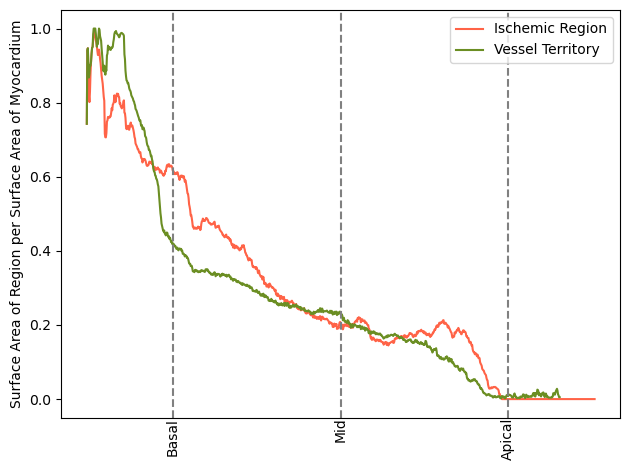

In [51]:
import matplotlib.pyplot as plt

plt.plot(SurfaceArea_I, label = "Ischemic Region", color = "tomato")
plt.plot(SurfaceArea_T, label = "Vessel Territory", color = "olivedrab")
plt.ylabel("Surface Area of Region per Surface Area of Myocardium")
plt.xticks([])

x_min, x_max = plt.xlim()
lines_x = [x_min + (x_max - x_min) * frac for frac in [1/5, 1/2, 4/5]]
labels = ['Basal', 'Mid', 'Apical']

for i, x_pos in enumerate(lines_x):
    plt.axvline(x=x_pos, color='gray', linestyle='--')
    plt.text(x_pos , plt.ylim()[0], labels[i], rotation=90, va='top', ha='center')

plt.legend()
plt.tight_layout()
plt.show()